In [1]:
!pip install librosa
!pip install pydub
!pip install glob2
!pip install yagmail
!pip install ffmpeg
!ffmpeg -version

ffmpeg version 7.0.2-full_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
built with gcc 13.2.0 (Rev5, Built by MSYS2 project)
configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-liblen

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import yagmail
import getpass
import datetime
import pywhatkit
from pydub import AudioSegment
import numpy as np
import os
import glob2
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from shutil import which
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Constants
SAMPLING_RATE = 22050  # Standard sampling rate for audio files
SAMPLES_PER_TRACK = SAMPLING_RATE * 30  # Assume 30-second tracks
TOTAL_SEGMENTS = 10  # Number of segments for feature extraction
DATASET_PATH = "./genres_original"
UPLOADED_PATH = './Qyamat.mp3'  # Example path to an uploaded file
AudioSegment.converter = "./ffmpeg.exe"

In [10]:
# Function to extract MFCC features from an audio file
def extract_mfcc_feature(file_path, num_mfcc=13, n_fft=2048, hop_length=512):
    print(f"Source file path: {file_path}")
    try:
        y, sr = librosa.load(file_path, sr=SAMPLING_RATE)
        print("Loaded audio for MFCC extraction.")
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        return mfcc.T  # Transpose to get shape (time, mfcc_features)
    except Exception as e:
        print(f"Error loading audio for MFCC extraction: {e}")
        raise

# Function to convert MP3 files to WAV format
def convert_mp3_to_wav(mp3_path):
    if not mp3_path.endswith('.mp3'):
        print("The provided file does not have a .mp3 extension.")
        return None

    wav_path = mp3_path.replace('.mp3', '.wav')
    AudioSegment.converter = which("ffmpeg")
    
    try:
        audio = AudioSegment.from_mp3(mp3_path)
        audio.export(wav_path, format="wav")
        if os.path.exists(wav_path):
            print(f"Converted .mp3 file into .wav file: {wav_path}")
        else:
            print(f"Conversion failed, {wav_path} was not created.")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return wav_path

# Function to preprocess audio file
def preprocess_mfcc(mfcc_features, expected_shape):
    # Truncate or pad the MFCC features
    if mfcc_features.shape[0] > expected_shape[0]:
        # Truncate the MFCC features
        mfcc_features = mfcc_features[:expected_shape[0], :]
    elif mfcc_features.shape[0] < expected_shape[0]:
        # Pad the MFCC features with zeros
        padding = expected_shape[0] - mfcc_features.shape[0]
        mfcc_features = np.pad(mfcc_features, ((0, padding), (0, 0)), mode='constant')

    # Add the channel dimension
    mfcc_features = np.expand_dims(mfcc_features, axis=-1)

    return mfcc_features
# Function to make genre predictions based on an audio file
def do_prediction(model):
    genre_pred = {
        0: "blues",
        1: "classical",
        2: "country",
        3: "disco",
        4: "hiphop",
        5: "jazz",
        6: "metal",
        7: "pop",
        8: "reggae",
        9: "rock",
    }

    # Convert MP3 to WAV first
    wav_path = convert_mp3_to_wav(UPLOADED_PATH)
    print(".wav is stored in the path : " + wav_path)
    
    # Extract MFCC features
    mfcc_features = extract_mfcc_feature(wav_path)

    # Preprocess MFCC to match the expected input shape
    expected_shape = (130, 13)  # Replace with the actual expected shape of your model
    mfcc_features = preprocess_mfcc(mfcc_features, expected_shape)

    # Expand dimensions to create a batch (batch_size, time_steps, num_features, channels)
    mfcc_features = np.expand_dims(mfcc_features, axis=0)

    # Perform prediction
    prediction = model.predict(mfcc_features)
    predicted_ind = np.argmax(prediction, axis=1)[0]  # Get the index of the predicted genre

    # Map the predicted index to the genre name
    predicted_genre = genre_pred.get(predicted_ind, "Unknown Genre")

    return predicted_genre

# Function to plot the training history of the model
def plot_performance_history(hist):
    figure, ax = plt.subplots(2)
    ax[0].plot(hist.history["accuracy"], label="Training Accuracy")
    ax[0].plot(hist.history["val_accuracy"], label="Validation Accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(loc="lower right")
    ax[0].set_title("Accuracy Check")

    ax[1].plot(hist.history["loss"], label="Training Loss")
    ax[1].plot(hist.history["val_loss"], label="Validation Loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(loc="upper right")
    ax[1].set_title("Loss Evaluation")

    plt.show()

# Function to extract MFCC features from all audio files in the dataset
def extract_all_mfcc_feature():
    value_each_seg = int(SAMPLES_PER_TRACK / TOTAL_SEGMENTS)
    data_mfcc = []
    data_label = []

    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    i = 0
    for genre in genres:
        filenames = glob2.glob(os.path.join(DATASET_PATH, genre, '*.wav'))
        if not filenames:
            print(f"No files found for genre: {genre}")
            continue
        for file in filenames:
            y, sr = librosa.load(file, sr=SAMPLING_RATE)
            for d in range(TOTAL_SEGMENTS):
                start = value_each_seg * d
                finish = start + value_each_seg
                mfcc = librosa.feature.mfcc(y=y[start:finish], sr=sr, n_mfcc=13)
                mfcc = mfcc.T
                if len(mfcc) == 130:
                    data_mfcc.append(mfcc.tolist())
                    data_label.append(i)
        i += 1

    return np.array(data_mfcc), np.array(data_label)

# Function to create a CNN model for genre classification
def create_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

# Function to prepare the dataset for training, validation, and testing
def dataset_preparation(split_test_size, split_validation_size):
    data_mfcc, data_label = extract_all_mfcc_feature()

    if data_mfcc.size == 0:
        raise ValueError("No data found. Ensure the dataset path and files are correct.")

    train_data, test_data, train_label, test_label = train_test_split(data_mfcc, data_label, test_size=split_test_size, random_state=42)
    train_data, validation_data, train_label, validation_label = train_test_split(train_data, train_label, test_size=split_validation_size, random_state=42)

    train_data = train_data[..., np.newaxis]
    validation_data = validation_data[..., np.newaxis]
    test_data = test_data[..., np.newaxis]

    return train_data, validation_data, test_data, train_label, validation_label, test_label





Epoch 1/30


219/219 [==============================] - ETA: 0s - loss: 2.2374 - accuracy: 0.2763

F:\Anaconda\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 30s 46ms/step - loss: 2.2374 - accuracy: 0.2763 - val_loss: 1.7811 - val_accuracy: 0.3974
Epoch 2/30
219/219 [==============================] - 8s 35ms/step - loss: 1.7218 - accuracy: 0.3993 - val_loss: 1.5047 - val_accuracy: 0.4545
Epoch 3/30
219/219 [==============================] - 7s 32ms/step - loss: 1.5094 - accuracy: 0.4576 - val_loss: 1.3754 - val_accuracy: 0.5105
Epoch 4/30
219/219 [==============================] - 7s 32ms/step - loss: 1.4014 - accuracy: 0.4996 - val_loss: 1.2864 - val_accuracy: 0.5355
Epoch 5/30
219/219 [==============================] - 7s 32ms/step - loss: 1.3251 - accuracy: 0.5198 - val_loss: 1.2575 - val_accuracy: 0.5455
Epoch 6/30
219/219 [==============================] - 7s 32ms/step - loss: 1.2559 - accuracy: 0.5536 - val_loss: 1.2194 - val_accuracy: 0.5606
Epoch 7/30
219/219 [==============================] - 7s 32ms/step - loss: 1.2038 - accuracy: 0.5763 - val_loss: 1.1946 - val_accuracy: 0.5636
Epoch 8/3

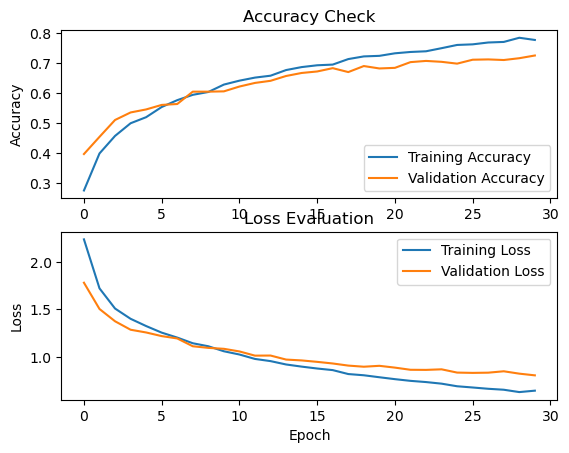

63/63 [==============================] - 1s 11ms/step - loss: 0.7665 - accuracy: 0.7362
Test Loss: 0.7664926648139954
Test Accuracy: 0.7362362146377563


In [4]:
# Main block to run the model training and evaluation
if __name__ == "__main__":
    # Prepare dataset
    train_data, validation_data, test_data, train_label, validation_label, test_label = dataset_preparation(0.20, 0.125)
    input_shape = (train_data.shape[1], train_data.shape[2], 1)
    
    # Create model
    model = create_model(input_shape)

    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Set up callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    # Train model with early stopping and checkpointing
    hist = model.fit(train_data, train_label,
                     validation_data=(validation_data, validation_label),
                     epochs=30,
                     batch_size=32,
                     callbacks=[early_stopping, model_checkpoint])

    # Plot performance history
    plot_performance_history(hist)

    # Load the best model saved by ModelCheckpoint
    model.load_weights('best_model.h5')

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(test_data, test_label)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")


In [ ]:
# Function to display MFCC features of a song
def display_mfcc(song, title):
    y, _ = librosa.load(song)
    mfcc = librosa.feature.mfcc(y=y)

    plt.figure(figsize=(6, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Function to send email updates
def send_email_update(FROM='your_email@gmail.com', TO='recipient_email@example.com', TEXT="Hi"):
    password = getpass.getpass('Enter Your Email Password')
    yag = yagmail.SMTP(user=FROM, password=password, host='smtp.gmail.com')
    SUB = "Genre update on your uploaded song"
    yag.send(to=TO, subject=SUB, contents=TEXT)
    print("Email sent Successfully!")

# Function to send WhatsApp updates
def send_whatsapp_update(msg='Hi', mob="+919051687802"):
    now = datetime.datetime.now()
    hr = now.hour
    mins = now.minute + 2  # Send the message two minutes from now


In [9]:
do_prediction(model)

Conversion complete: ./Qyamat.wav
we got the path: ./Qyamat.wav
Source file path: ./Qyamat.wav
Loaded audio for MFCC extraction.
1/1 [==============================] - 0s 47ms/step


'country'